In [19]:
from dataclasses import dataclass
import amrex.space3d as amr
import numpy as np
import matplotlib.pyplot as plt

if not amr.initialized():
    amr.initialize([])

In [37]:
plt_file_name = "/home/qfister/aa_Project/FHDeX/exec/immersed_boundary/cell_body/plt_data/plt0004400"

In [38]:
@dataclass
class Particle:
    x: float
    y: float
    z: float
    ib_id: int
    idx: int

In [39]:
def load_particle_data(plt_file_name):
    plt = amr.PlotFileData(plt_file_name)

    probDomain = plt.probDomain(0)
    probLo = plt.probLo()
    probHi = plt.probHi()
    domain_box = amr.Box(probDomain.small_end, probDomain.big_end)
    real_box = amr.RealBox(probLo, probHi)
    std_geometry = amr.Geometry(domain_box, real_box, plt.coordSys(), [0, 0, 0])

    pc = amr.ParticleContainer_16_4_0_0_default(
        std_geometry,
        plt.DistributionMap(plt.finestLevel()),
        plt.boxArray(plt.finestLevel()),
    )
    pc.restart(plt_file_name, "immbdy_markers")

    particles = []
    for pti in pc.iterator(pc, level=plt.finestLevel()):
        aos = pti.aos()
        for p in aos.to_numpy(copy=True):
            particles.append(Particle(x=p[0], y=p[1], z=p[2], ib_id=int(p[-1]), idx=int(p[-2])))

    return particles, probLo, probHi

In [40]:
def load_pressure_data(plt_file_name):
    plt_data = amr.PlotFileData(plt_file_name)
    dom = plt_data.probDomain(0)
    box_size = [i + 1 for i in dom.hi_vect] 
    center = [int(i / 2) for i in dom.hi_vect]
    mfab_pres = plt_data.get(0, "pres")
    pres_data = np.zeros(box_size)

    for mfi in mfab_pres:
        marr = mfab_pres.array(mfi)
        vb = mfi.validbox()
        lo = list(vb.lo_vect)
        hi = list(vb.hi_vect)
        data = marr.to_xp()[:, :, :, 0]
        pres_data[lo[0]:hi[0] + 1, lo[1]:hi[1] + 1, lo[2]:hi[2] + 1] = data

    return pres_data, center

In [41]:
def min_dis(particles):
    particles_0 = [p for p in particles if p.ib_id == 0 and p.idx == 21]  #indicates reference marker on flagellum
    particles_1 = [p for p in particles if p.ib_id == 1 and p.idx != 47]
    
    min_d = float('inf')
    closest_mkrs = (None, None)
    
    for p0 in particles_0:
        for p1 in particles_1:
            distance = np.sqrt((p0.x - p1.x)**2 + (p0.y - p1.y)**2 + (p0.z - p1.z)**2)
            if distance < min_d:
                min_d = distance
                closest_mkrs = (p0, p1)
    
    return closest_mkrs, min_d

In [42]:
particles, probLo, probHi = load_particle_data(plt_file_name)
pres_data, center = load_pressure_data(plt_file_name)

In [43]:
x_vals = [(p.x - probLo[0]) / (probHi[0] - probLo[0]) * pres_data.shape[0] for p in particles]
y_vals = [(p.y - probLo[1]) / (probHi[1] - probLo[1]) * pres_data.shape[1] for p in particles]

Flagellum Particle(x=0.0017489351747160724, y=0.001296516105324492, z=0.001, ib_id=0, idx=21)
Cell Body Particle(x=0.0017192702915988383, y=0.0015738665235010807, z=0.0010221652292449405, ib_id=1, idx=81)

Distance between flagellum end marker and closest cell body marker 2.7981164582727542


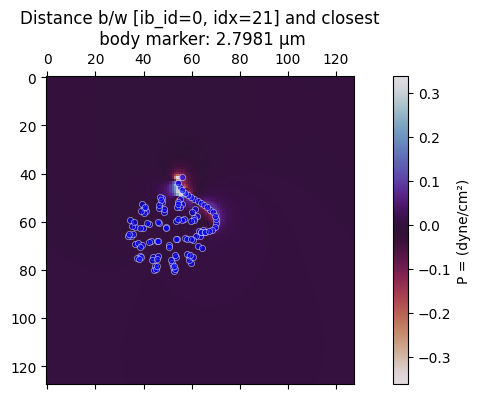

In [50]:
closest_mkrs, min_d = min_dis(particles)

plt.figure(figsize=(10, 4))
plt.scatter(x_vals, y_vals, c='b', marker='o', s=20, alpha=0.6, edgecolors='w', linewidths=0.5)

plt.matshow(np.transpose(pres_data[:, :, center[2]]), cmap='twilight_r', fignum=False)
plt.colorbar(label='P = (dyne/cm²)')

plt.title(f"Distance b/w [ib_id=0, idx=21] and closest\n body marker: {min_d * 10000:.4f} µm")

print("Flagellum", closest_mkrs[0])
print("Cell Body", closest_mkrs[1])
print("\nDistance between flagellum end marker and closest cell body marker", min_d *10000)